In [ ]:
import itertools as it
import os
import time
from datetime import datetime
import pandas as pd
import numpy as np
import pandas as pd
import random
import vitaldb
from pyvital2 import arr
import pickle
import matplotlib.pyplot as plt
import scipy.stats


BATCH_SIZE = 1024
MAX_CASES = 2000
SEGLEN_IN_SEC = 20
SRATE = 100
LEN_INPUT = 20
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 120


# 피크 사이 wave를 모두 같은 length로 만들기 위한 함수
def linear_connection(list, idx):
    int_idx = int(idx)
    return list[int_idx] + (list[int_idx+1] - list[int_idx]) * (idx - int_idx)


file_path = 'vital_to_np'

# path for cache
if not os.path.exists('./cache'):
    os.mkdir('./cache')
if not os.path.exists('./cache/peaks'):
    os.mkdir('./cache/peaks')
if not os.path.exists(f"cache/peaks/PPG_{SRATE}Hz_1min_seg"):
    os.mkdir(f"cache/peaks/PPG_{SRATE}Hz_1min_seg")
if not os.path.exists(f"cache/peaks/ECG_{SRATE}Hz_1min_seg"):
    os.mkdir(f"cache/peaks/ECG_{SRATE}Hz_1min_seg")        
if not os.path.exists('./cache/preprocess'):
    os.mkdir('./cache/preprocess')


# dataframe to save preprocessing info
n_aug = int((LEN_PER_PRE-LEN_INPUT)/OVERLAP) + 1   # number of data augmentation
n_aug2 = int((LEN_PER_POST-LEN_INPUT)/OVERLAP) + 1
column_list = ['caseid'] + [str(i+1) for i in range(n_aug+n_aug2)]
df_preprocess = pd.DataFrame(columns = column_list)


# set variables
caseids = os.listdir(file_path)
error_list = []
f_num = 0
initial = f_num
interval = len(caseids)


for caseid in caseids[initial:initial+interval]:
    caseid = caseid[:-4]
    f_num += 1
    print('\n###Input', f_num,'/ '+str(len(caseids))+': '+caseid+'###')


    # vital data 불러오기    
    vals = np.load(f'{file_path}/{caseid}.npz')


    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'caseid'] = caseid

    ppg_cache = f"cache/peaks/PPG_{SRATE}Hz_1min_seg/" + caseid
    ecg_cache = f"cache/peaks/ECG_{SRATE}Hz_1min_seg/" + caseid    
    ecg_cache2 = f"cache/peaks/ECG_{SRATE}Hz_1min_seg/" + caseid


    # 20초 단위로 끊기
    for i in range(n_aug):
        print('  segment', i+1, end='')
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000


        ### non-event input ###
        seg_ppg = vals['nPPG'][start_idx:end_idx]
        seg_ecg = vals['nECG'][start_idx:end_idx]


        ## 1. 결측치 처리 ##             
        # df.isnull().sum() 하면 더 간단하게 가능하나 애초에 NRS에 해당하는 vital data가 120초 보다 짧은 경우
        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE

        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]

        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05 or nan_both_perc > 0.05:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-1, -1])
            print('too much missing data')
            continue


        ## 2. Noise 처리 ##
        # peak detection
        if os.path.exists(ppg_cache+'_n{}'.format(i+1)):
            _, ppg_peak = pickle.load(open(ppg_cache+'_n{}'.format(i+1), 'rb'))
            ecg_peak = pickle.load(open(ecg_cache+'_n{}'.format(i+1), 'rb'))
            print('...loaded peak...', end='')


        else:
            try:
                min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                ecg_peak = arr.detect_qrs(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)


            except Exception as e:
                print('error of', e)
                error_list.append(caseid)
                df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-3, -3])
                continue


            if len(ppg_peak)==0:
                print('no peak')


            pickle.dump((min_peak, ppg_peak), open(ppg_cache+'_n{}'.format(i+1), 'wb'))
            pickle.dump(ecg_peak, open(ecg_cache+'_n{}'.format(i+1), 'wb'))
            print('...saved peak...', end='')


        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak
        idx_ecg_peak = ecg_peak


        # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-2, -2])
            print('too less peaks')
            continue


        # 20초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]

        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]


        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
                bool_noise_ecg[k] = True


        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 2*SRATE
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])

        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])


        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)

        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)

        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]

        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.05 and nan_ecg_perc < 0.05 and nan_both_perc < 0.05 and noise_ppg_perc < 0.1 and noise_ecg_perc < 0.1:
            bool_pass = True
        else:
            bool_pass = False

        # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
        arry = np.empty(1, dtype=object)
        arry[0] = [bool_pass, nan_info, noise_info, 0, 0]
        df_preprocess.loc[f_num-1,f'{i+1}'] = arry[0] #{'pass':bool_pass, 'nan_perc':nan_info, 'noise_perc':noise_info, 'tss':0, 'cisa':0}        
        print('preprocessing done...', end='')
        ##########################################################################


    for i in range(n_aug2):
        print('  segment', i+1, end='')
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000


        ### event input ###
        seg_ppg = vals['PPG'][start_idx:end_idx]
        seg_ecg = vals['ECG'][start_idx:end_idx]


        ## 1. 결측치 처리 ##              
        # df.isnull().sum() 하면 더 간단하게 가능하나 애초에 NRS에 해당하는 vital data가 120초 보다 짧은 경우
        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE

        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]

        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05 or nan_both_perc > 0.05:
            df_preprocess.loc[f_num-1,str(i+n_aug+1)] = (False, nan_info, [-1, -1])
            print('too much missing data')
            continue


        ## 2. Noise 처리 ##
        # peak detection
        if os.path.exists(ppg_cache+'_{}'.format(i+1)):
            _, ppg_peak = pickle.load(open(ppg_cache+'_{}'.format(i+1), 'rb'))
            ecg_peak = pickle.load(open(ecg_cache+'_{}'.format(i+1), 'rb'))
            print('...loaded peak...', end='')


        else:
            try:
                min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                ecg_peak = arr.detect_qrs(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)


            except Exception as e:
                print('error of', e)
                error_list.append(caseid)
                df_preprocess.loc[f_num-1,str(i+n_aug+1)] = (False, nan_info, [-3, -3])
                continue


            if len(ppg_peak)==0:
                print('no peak')


            pickle.dump((min_peak, ppg_peak), open(ppg_cache+'_{}'.format(i+1), 'wb'))
            pickle.dump(ecg_peak, open(ecg_cache+'_{}'.format(i+1), 'wb'))
            print('...saved peak...', end='')


        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak
        idx_ecg_peak = ecg_peak


        # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
            df_preprocess.loc[f_num-1,str(i+n_aug+1)] = (False, nan_info, [-2, -2])
            print(' too less peaks', end='...')
            continue


        # 20초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]

        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]


        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
                bool_noise_ecg[k] = True


        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 2*SRATE
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])

        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])


        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)


        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)


        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]

        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.05 and nan_ecg_perc < 0.05 and nan_both_perc < 0.05 and noise_ppg_perc < 0.1 and noise_ecg_perc < 0.1:
            bool_pass = True
        else:
            bool_pass = False


        # 통증 점수 계산
        ### TSS(total surgical stimulation) = 1.57 - rftn20_ce / 3
        ### CISA(combined index of stimulus and analgesia) = stim_intensity - beta * ce + gamma, beta = 1/8, gamma = 1.5, stim_intensity = 5.5 
        rftn = vals['RFTN'][start_idx:end_idx]
        rftn = np.mean(rftn[~np.isnan(rftn)])
        tss = 1.57 - rftn / 3
        if tss < 0:
            tss = 0
        cisa = 7 - rftn / 8

        # 이 segment의 정보를 dataframe에 저장
        arry = np.empty(1, dtype=object)
        arry[0] = [bool_pass, nan_info, noise_info, tss, cisa]
        df_preprocess.loc[f_num-1,f'{i+n_aug+1}'] = arry[0] #{'pass':bool_pass, 'nan_perc':nan_info, 'noise_perc':noise_info, 'tss':0, 'cisa':0}            
        print('preprocessing done...', end='')            

print(f'\ndumping cache of df_preprocess {f_num}/{len(caseids)}', end='...')

# df_preprocess에 demographs(age, gender) 추가
df_demograph = pd.read_csv("https://api.vitaldb.net/cases")
df_preprocess['age'] = np.nan
df_preprocess['gender'] = np.nan

for idx, row in df_preprocess.iterrows():     
    row_demo = df_demograph[df_demograph['caseid']==int(row['caseid'])]

    df_preprocess.loc[idx, 'age'] = row_demo['age'].values[0]
    df_preprocess.loc[idx, 'gender'] = row_demo['sex'].values[0]

df_preprocess.reset_index(drop=True, inplace=True)    
pickle.dump(df_preprocess, open('cache/preprocess/df_preprocess', 'wb'))
print('dumping success')

# 전처리 통과 비율 출력
ne_pass, e_pass = 0, 0

for _, row in df_preprocess.iterrows():   
    for i in range(n_aug):
        if row[str(i+1)][0]:
            ne_pass = ne_pass + 1

    for i in range(n_aug, n_aug+n_aug2):
        if row[str(i+1)][0]:
            e_pass = e_pass + 1

print(f'non-event seg pass: {ne_pass/n_aug/2684*100:.2f}%, event seg pass: {e_pass/n_aug2/2684*100:.2f}%')
print(f'passed segments : {ne_pass+e_pass}')


###Input 1 / 2684: 5974###
  segment 1...loaded peak...preprocessing done...  segment 2...loaded peak...

/home/painstudy/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


preprocessing done...  segment 3...loaded peak...preprocessing done...  segment 4...loaded peak...preprocessing done...  segment 5...loaded peak...preprocessing done...  segment 1...loaded peak...preprocessing done...  segment 2...loaded peak...preprocessing done...  segment 3...loaded peak...preprocessing done...  segment 4...loaded peak...preprocessing done...  segment 5...loaded peak...preprocessing done...  segment 6...loaded peak...preprocessing done...  segment 7...loaded peak...preprocessing done...  segment 8...loaded peak...preprocessing done...  segment 9...loaded peak...preprocessing done...  segment 10...loaded peak...preprocessing done...  segment 11...loaded peak...preprocessing done...
###Input 2 / 2684: 801###
  segment 1...loaded peak...preprocessing done...  segment 2...loaded peak...preprocessing done...  segment 3...loaded peak...preprocessing done...  segment 4...loaded peak...preprocessing done...  segment 5...loaded peak...preprocessing done...  segment 1...loade

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


preprocessing done...  segment 8...loaded peak...preprocessing done...  segment 9...loaded peak...preprocessing done...  segment 10...loaded peak...preprocessing done...  segment 11...loaded peak...preprocessing done...
###Input 322 / 2684: 1639###
  segment 1...loaded peak...preprocessing done...  segment 2...loaded peak...too less peaks
  segment 3...loaded peak...too less peaks
  segment 4...loaded peak...too less peaks
  segment 5...loaded peak...too less peaks
  segment 1...loaded peak...preprocessing done...  segment 2...loaded peak...preprocessing done...  segment 3...loaded peak...preprocessing done...  segment 4...loaded peak...preprocessing done...  segment 5...loaded peak...preprocessing done...  segment 6...loaded peak...preprocessing done...  segment 7...loaded peak...preprocessing done...  segment 8...loaded peak...preprocessing done...  segment 9...loaded peak...preprocessing done...  segment 10...loaded peak...preprocessing done...  segment 11...loaded peak...preprocess

In [6]:
df_preprocess = pickle.load(open('../Preprocess/cache/preprocess/df_preprocess', 'rb'))
caseid_test = pickle.load(open('../DL_model/caseid_test', 'rb'))
caseid_train = pickle.load(open('../DL_model/caseid_train', 'rb'))
caseid_val = pickle.load(open('../DL_model/caseid_val', 'rb'))
    

# variables
non_lis = []
x_train, tss_train, cisa_train = [], [], []
x_test, tss_test, cisa_test = [], [], []
x_val, tss_val, cisa_val = [], [], []
age_train, gender_train = [], []
age_test, gender_test = [], []
age_val, gender_val = [], []
     

for f_num, row in df_preprocess.iterrows():
    caseid = row['caseid']
    print(f'\n###Input{f_num}/{len(df_preprocess)}: {caseid}###')

    # vital data 불러오기    
    vals = np.load(f'{file_path}/{caseid}.npz')
    

    # 20초 단위로 끊기
    for i in range(n_aug):
        print('  n_segment', i+1, end='')
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000
        
        # non-event data
        if row[str(i+1)][0]:
            print(' passed...lowess filtering...', end='')

            # 해당 caseid가 test set에 속하는 경우
            if row['caseid'] in caseid_test:
                tss_test.append(row[str(i+1)][3])
                cisa_test.append(row[str(i+1)][4])

            # 해당 caseid가 val set에 해당하는 경우
            elif row['caseid'] in caseid_val:
                tss_val.append(row[str(i+1)][3])
                cisa_val.append(row[str(i+1)][4])

            # 해당 caseid가 train set에 해당하는 경우
            elif row['caseid'] in caseid_train:
                tss_train.append(row[str(i+1)][3])
                cisa_train.append(row[str(i+1)][4])

            else:
                print('no case%$')
                non_lis.append(row['caseid'])

            #np.savez(save_path, ECG = ecg_input, PPG = ppg_input)
            print('done', end=' ')
    
    print('')
    for i in range(n_aug2):
        print('  segment', i+1, end='')
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000
            
        # event data
        if row[str(i+n_aug+1)][0]:
            print(' passed...lowess filtering...', end='')
            # 해당 caseid가 test set에 속하는 경우
            if row['caseid'] in caseid_test:

                tss_test.append(row[str(i+n_aug+1)][3])
                cisa_test.append(row[str(i+n_aug+1)][4])

            # 해당 caseid가 val set에 해당하는 경우
            elif row['caseid'] in caseid_val:

                tss_val.append(row[str(i+n_aug+1)][3])
                cisa_val.append(row[str(i+n_aug+1)][4])

            # 해당 caseid가 train set에 해당하는 경우
            elif row['caseid'] in caseid_train:

                tss_train.append(row[str(i+n_aug+1)][3])
                cisa_train.append(row[str(i+n_aug+1)][4])

            else:
                print('no case%$')
                non_lis.append(row['caseid'])                 
            
            #np.savez(save_path, ECG = ecg_input, PPG = ppg_input) 
            print('done', end=' ')


tss_train = np.array(tss_train, np.float32)
tss_test = np.array(tss_test, np.float32)
tss_val = np.array(tss_val, np.float32)
cisa_train = np.array(cisa_train, np.float32)
cisa_test = np.array(cisa_test, np.float32)
cisa_val = np.array(cisa_val, np.float32)



input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"
# 저장하기
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'tss_train.npz', tss_train)
np.savez_compressed(input_path+'tss_test.npz', tss_test)
np.savez_compressed(input_path+'tss_val.npz', tss_val)
np.savez_compressed(input_path+'cisa_train.npz', cisa_train)
np.savez_compressed(input_path+'cisa_test.npz', cisa_test)
np.savez_compressed(input_path+'cisa_val.npz', cisa_val)


print('done', flush=True)


###Input0/2684: 5974###
  n_segment 1 passed...lowess filtering...done   n_segment 2 passed...lowess filtering...done   n_segment 3 passed...lowess filtering...done   n_segment 4 passed...lowess filtering...done   n_segment 5 passed...lowess filtering...done 
  segment 1 passed...lowess filtering...done   segment 2 passed...lowess filtering...done   segment 3 passed...lowess filtering...done   segment 4 passed...lowess filtering...done   segment 5 passed...lowess filtering...done   segment 6 passed...lowess filtering...done   segment 7 passed...lowess filtering...done   segment 8 passed...lowess filtering...done   segment 9 passed...lowess filtering...done   segment 10 passed...lowess filtering...done   segment 11 passed...lowess filtering...done 
###Input1/2684: 801###
  n_segment 1 passed...lowess filtering...done   n_segment 2 passed...lowess filtering...done   n_segment 3 passed...lowess filtering...done   n_segment 4 passed...lowess filtering...done   n_segment 5 passed...lowess 

In [5]:
df_preprocess

,caseid,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,age,gender
0,5974,"[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.03846153846153...","[True, [0.0, 0.0, 0.0], [0.0, 0.04], 0.0341666...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.07766674...","[True, [0.0, 0.0, 0.0], [0.038461538461538464,...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.17106674...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.21976660...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.26688328...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.31273339...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.35754997...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.40108329...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.44484844...",49.0,F
1,801,"[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[False, [0.0, 0.0, 0.0], [0.03225806451612903,...","[False, [0.0, 0.0, 0.0], [0.03225806451612903,...","[False, [0.0, 0.0, 0.0], [0.09375, 0.892857142...","[False, [0.0, 0.0, 0.0], [0.23333333333333334,...","[False, [0.0, 0.0, 0.0], [0.3103448275862069, ...","[False, [0.0, 0.0, 0.0], [0.06451612903225806,...","[False, [0.0, 0.0, 0.0], [0.0, 0.2916666666666...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.05892434...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.09669445...","[False, [0.0, 0.0, 0.0], [0.15384615384615385,...","[False, [0.0, 0.0, 0.0], [0.24, 0.296296296296...",62.0,F
2,2790,"[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.04], 0.2393665...","[True, [0.0, 0.0, 0.0], [0.0, 0.08], 0.2391282...","[True, [0.0, 0.0, 0.0], [0.0, 0.08], 0.2395554...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.24490474...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.25905552...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.27888876...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.30361118...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.33833335...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.36210003...","[True, [0.0, 0.0, 0.0], [0.0, 0.09523809523809...","[True, [0.0, 0.0, 0.0], [0.0, 0.09523809523809...",60.0,F
3,1413,"[True, [0.0, 0.0, 0.0], [0.0, 0.05], 0, 0]","[True, [0.0, 0.0, 0.0], [0.05, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.047619047619047616,...","[False, [0.0, 0.0, 0.0], [0.0, 0.1], 0, 0]","[False, [0.0, 0.0, 0.0], [0.0, 0.2], 0, 0]","[False, [0.0, 0.0, 0.0], [0.18181818181818182,...","[False, [0.0, 0.0, 0.0], [0.5, 0.1739130434782...","[False, [0.0, 0.0, 0.0], [0.42857142857142855,...","[False, [0.0, 0.0, 0.0], [0.5882352941176471, ...","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [-2, -2])","[False, [0.0, 0.0, 0.0], [1.0, 0.0476190476190...","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [-2, -2])","[False, [0.0, 0.0, 0.0], [1.0, 0.05], 0, 6.374...","[False, [0.0, 0.0, 0.0], [1.0, 0.0], 0, 6.3747...",48.0,M
4,4057,"[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0625, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 6.37558...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 6.37552...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 6.37550...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 6.37545...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 6.37535...","[True, [0.0, 0.0, 0.0], [0.058823529411764705,...","[True, [0.0, 0.0, 0.0], [0.058823529411764705,...","[False, [0.0, 0.0, 0.0], [0.058823529411764705...","[True, [0.0, 0.0, 0.0], [0.0, 0.05882352941176...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 6.37508...","[True, [0.0, 0.0

In [11]:
df_preprocess[df_preprocess['caseid']=='2116']

,caseid,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,age,gender
909,2116,"(False, [0.0, 0.0, 0.0], [-2, -2])","[False, [0.0, 0.0, 0.0], [1.0, 1.0], 0, 0]","[False, [0.0, 0.0, 0.0], [1.0, 1.0], 0, 0]","[False, [0.0, 0.0, 0.0], [1.0, 1.0], 0, 0]","(False, [0.0, 0.0, 0.0], [-2, -2])","[False, [0.0, 0.0, 0.0], [0.17857142857142858,...","[False, [0.0, 0.0, 0.0], [0.2413793103448276, ...","[False, [0.0, 0.0, 0.0], [0.25, 0.0], 1.57, 7.0]","[True, [0.0, 0.0, 0.0], [0.030303030303030304,...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 1.57, 7.0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0625], 1.57, 7.0]","[True, [0.0, 0.0, 0.0], [0.0, 0.0625], 1.56021...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 1.43883334...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 1.17880303...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.86904548...","[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0.67173606...",55.0,F


## t_intu validation - rftn=0

In [7]:
df_preprocess = pickle.load(open('../Preprocess/cache/preprocess/df_preprocess', 'rb'))
caseid_test = pickle.load(open('../DL_model/caseid_test', 'rb'))
caseid_train = pickle.load(open('../DL_model/caseid_train', 'rb'))
caseid_val = pickle.load(open('../DL_model/caseid_val', 'rb'))
    

# variables
rft0_lis = []
non_lis = []
x_train, tss_train, cisa_train = [], [], []
x_test, tss_test, cisa_test = [], [], []
x_val, tss_val, cisa_val = [], [], []
age_train, gender_train = [], []
age_test, gender_test = [], []
age_val, gender_val = [], []
     

for f_num, row in df_preprocess.iterrows():
    caseid = row['caseid']
    print(f'\n###Input{f_num}/{len(df_preprocess)}: {caseid}###')

    # vital data 불러오기    
    vals = np.load(f'{file_path}/{caseid}.npz')
    

    # 20초 단위로 끊기
    for i in range(n_aug):
        #print('  n_segment', i+1, end='')
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000
        
        if row[str(i+1)][0]:
            #print(' passed...lowess filtering...', end='')        
            if row[str(i+1)][3]==1.57:
                rft0_lis.append(caseid)
        

    #print('')
    for i in range(n_aug2):
        #print('  segment', i+1, end='')
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000
            
        # event data
        if row[str(i+n_aug+1)][0]:
            if row[str(i+n_aug+1)][3]==1.57:
                rft0_lis.append(caseid)


rft0_lis


###Input0/2684: 5974###

###Input1/2684: 801###

###Input2/2684: 2790###

###Input3/2684: 1413###

###Input4/2684: 4057###

###Input5/2684: 1698###

###Input6/2684: 2084###

###Input7/2684: 845###

###Input8/2684: 83###

###Input9/2684: 5976###

###Input10/2684: 3923###

###Input11/2684: 1349###

###Input12/2684: 3907###

###Input13/2684: 4108###

###Input14/2684: 263###

###Input15/2684: 4885###

###Input16/2684: 104###

###Input17/2684: 684###

###Input18/2684: 121###

###Input19/2684: 2413###

###Input20/2684: 6095###

###Input21/2684: 3991###

###Input22/2684: 584###

###Input23/2684: 3417###

###Input24/2684: 4503###

###Input25/2684: 2419###

###Input26/2684: 6278###

###Input27/2684: 6128###

###Input28/2684: 1906###

###Input29/2684: 1490###

###Input30/2684: 4868###

###Input31/2684: 1992###

###Input32/2684: 5566###

###Input33/2684: 1030###

###Input34/2684: 2770###

###Input35/2684: 3729###

###Input36/2684: 1638###

###Input37/2684: 1080###

###Input38/2684: 1251###

###I

['2116', '2116', '2116', '4814', '4814']

In [8]:
# ppf 
rft0_lis

['2116', '2116', '2116', '4814', '4814']

In [14]:
track_names = ["SNUADC/ECG_II", "SNUADC/PLETH", "Solar8000/VENT_INSP_TM", "Primus/SET_INSP_TM", "Orchestra/PPF20_CE", "Orchestra/RFTN20_CE"]


# create saving folder
file_path = "vital_to_np"
if not os.path.exists(file_path):
    os.mkdir(file_path)


# dataframe of patient information    
df = pd.read_csv("https://api.vitaldb.net/cases")


# target patients' caseids
caseids = list(vitaldb.caseids_tiva & set(df.loc[df['ane_type'] == 'General', 'caseid']))


caseid = 2116
print(f'caseid:{caseid}')
# check if file is already existing
filename = f'{file_path}/{caseid}.npz'


# get vital file and save as numpy
vf = vitaldb.VitalFile(caseid, track_names)
vals = vf.to_numpy(track_names, interval=1/SRATE)


# intubation time - find the first t which satisfies vent_set_tm != nan & ppf_ce != nan
t_intu = np.where(~np.isnan(vals[:,5]))[0][0]

if not np.mean(~np.isnan(vals[:,2])):
    if not np.mean(~np.isnan(vals[:,3])):
        print(f'caseid {caseid} - no valid data for insp_tm')
        
    intu = vals[:,3]
    intv = 850 # maximum interval for "Primus/SET_INSP_TM"
else:
    intu = vals[:,2]
    intv = 250 # maximum interval for "Solar8000/VENT_INSP_TM"

idc_intu = np.where(~np.isnan(intu))[0]
while True:
    # vent_insp_tm이 nan이 아닌 경우
    if not np.isnan(intu[t_intu]):
        print(t_intu, end=' ')
        idx = np.where(idc_intu==t_intu)[0][0]
        prev = t_intu

        switch = True
        for i in range(1,11):
            if idc_intu[idx+i] - prev > intv:
                switch = False
                t_intu = t_intu + 1
            prev = idc_intu[idx+i]
        if switch:
            break
    else:
        t_intu = t_intu + 1

caseid:2116
3098 

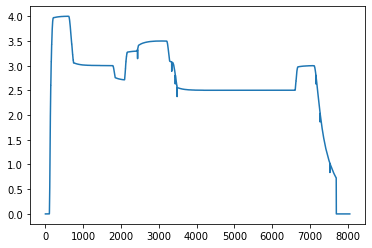

In [19]:
import matplotlib.pyplot as plt

rftn = vals[:,5]
plt.plot(rftn[~np.isnan(rftn)])
plt.show()

In [18]:
np.where(~np.isnan(vals[:,5]))[0][:100]

array([  221,   322,   423,   522,   623,   723,   823,   922,  1023,
        1122,  1223,  1325,  1423,  1523,  1624,  1723,  1824,  1923,
        2024,  2123,  2224,  2325,  2424,  2525,  2624,  2725,  2826,
        2925,  3024,  3125,  3225,  3325,  3425,  3524,  3625,  3726,
        3825,  3926,  4027,  4126,  4225,  4326,  4425,  4526,  4627,
        4726,  4827,  4927,  5027,  5126,  5226,  5327,  5426,  5527,
        5628,  5727,  5828,  5927,  6028,  6129,  6228,  6327,  6428,
        6527,  6628,  6729,  6828,  6929,  7029,  7128,  7229,  7328,
        7429,  7528,  7629,  7728,  7829,  7930,  8029,  8130,  8231,
        8330,  8429,  8530,  8631,  8730,  8830,  8930,  9030,  9131,
        9230,  9331,  9432,  9531,  9630,  9731,  9830,  9931, 10032,
       10131])

In [17]:
np.where(~np.isnan(intu))[0][:100]

array([ 3098,  3298,  3498,  3698,  3898,  4099,  4299,  4499,  4699,
        4899,  5099,  5299,  5499,  5699, 35900, 36101, 36300, 36500,
       36700, 36900, 37101, 37301, 37500, 37701, 37901, 38101, 38301,
       38501, 38701, 38901, 39101, 39301, 39501, 39701, 39901, 40101,
       40301, 40501, 40701, 40901, 41101, 41301, 41501, 41702, 41902,
       42102, 42302, 42502, 42702, 42902, 43102, 43302, 46302, 46502,
       46703, 46903, 47103, 47303, 47503, 47703, 47903, 48103, 48303,
       48504, 48704, 48904, 49104, 49303, 49504, 49704, 49904, 50104,
       50304, 50504, 50704, 50904, 51104, 51304, 51504, 51704, 51905,
       52105, 52304, 52504, 52705, 52904, 53104, 53305, 53505, 53704,
       53905, 54105, 54305, 54505, 54705, 54905, 55105, 55305, 55505,
       55705])